# TITLE

# Dataset setup


### Make labels on right format. COCO -> YOLO

In [4]:
ROOT   = Path("../data/CFC")
IMAGES = ROOT / "CFC_pic"

SPLIT_DIR = {"train": "cfc_train", "val": "cfc_val", "test": "cfc_test"}

def resolve_image_path(file_name, split):
    # Try the real split dir first
    p = IMAGES / SPLIT_DIR.get(split, split) / file_name
    if p.exists():
        return p
    # Fallbacks if JSON already contains subdirs or files are at root
    q = IMAGES / file_name
    if q.exists():
        return q
    r = IMAGES / split / file_name
    return r  # may not exist; caller will check

def convert(split, coco_json):
    labels_dir = ROOT / "labels" / split
    labels_dir.mkdir(parents=True, exist_ok=True)
    coco = json.loads(Path(coco_json).read_text())

    id2img = {im["id"]: im for im in coco["images"]}
    byimg = defaultdict(list)
    for a in coco["annotations"]:
        if a.get("iscrowd", 0) == 1 or a.get("ignore", 0) == 1:
            continue
        byimg[a["image_id"]].append(a)

    sorted_cats = sorted(coco["categories"], key=lambda c: c["id"])
    cat2idx = {c["id"]: i for i, c in enumerate(sorted_cats)}

    written = missing = 0
    for img_id, img in id2img.items():
        img_path = resolve_image_path(img["file_name"], split)
        if not img_path.exists():
            missing += 1
            continue

        W, H = img["width"], img["height"]
        lines = []
        for ann in byimg.get(img_id, []):
            x, y, w, h = ann["bbox"]
            x = clip(x, 0, W); y = clip(y, 0, H)
            w = clip(w, 0, W - x); h = clip(h, 0, H - y)
            if w <= 0 or h <= 0: 
                continue
            xc = (x + w / 2) / W
            yc = (y + h / 2) / H
            wn = w / W
            hn = h / H
            cls = cat2idx[ann["category_id"]]
            lines.append(f"{cls} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")

        if lines:
            (labels_dir / (Path(img["file_name"]).stem + ".txt")).write_text("\n".join(lines))
            written += 1

    print(f"{split}: wrote labels for {written} images; missing files: {missing}")

convert("train", ROOT/"CFC_ANN"/"cfc_train.json")
convert("val",   ROOT/"CFC_ANN"/"cfc_val.json")


train: wrote labels for 69654 images; missing files: 0
val: wrote labels for 9925 images; missing files: 0


### check if paths are ok


In [5]:
from pathlib import Path
import os, shutil

# Paths
NOT_ROOT = Path.cwd()              
ROOT = NOT_ROOT.parent
DATA = ROOT / "data" / "CFC"



# Define paths
IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL   = DATA / "images" / "val"
LABELS_TRAIN = DATA / "labels" / "train"
LABELS_VAL   = DATA / "labels" / "val"

# Check everything exists
for p in [IMAGES_TRAIN, IMAGES_VAL, LABELS_TRAIN, LABELS_VAL]:
    print(p, "✅ OK" if p.exists() else "❌ MISSING")


/Users/henrik/kode/SP/aqua_yolo/data/CFC/images/train ✅ OK
/Users/henrik/kode/SP/aqua_yolo/data/CFC/images/val ✅ OK
/Users/henrik/kode/SP/aqua_yolo/data/CFC/labels/train ✅ OK
/Users/henrik/kode/SP/aqua_yolo/data/CFC/labels/val ✅ OK


### Write yaml

In [8]:
from pathlib import Path

# Base paths
NOT_ROOT = Path.cwd()
ROOT = NOT_ROOT.parent

DATA = ROOT / "data" / "CFC"

IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL   = DATA    / "images" / "val"


# Build YAML (classic YOLO: train/val/test point to images dirs)
dataset_yaml = f"""
path: {DATA.as_posix()}
train: {IMAGES_TRAIN.as_posix()}
val:   {IMAGES_VAL.as_posix()}


nc: 1
names: 
    - fish
"""

# Write YAML next to the dataset
yaml_path = DATA / "cfc.yaml"
yaml_path.write_text(dataset_yaml.strip() + "\n", encoding="utf-8")

print("Wrote:", yaml_path)
print("\nPreview:\n")
print(dataset_yaml)


Wrote: /Users/henrik/kode/SP/aqua_yolo/data/CFC/cfc.yaml

Preview:


path: /Users/henrik/kode/SP/aqua_yolo/data/CFC
train: /Users/henrik/kode/SP/aqua_yolo/data/CFC/images/train
val:   /Users/henrik/kode/SP/aqua_yolo/data/CFC/images/val


nc: 1
names: 
    - fish



### Visualize

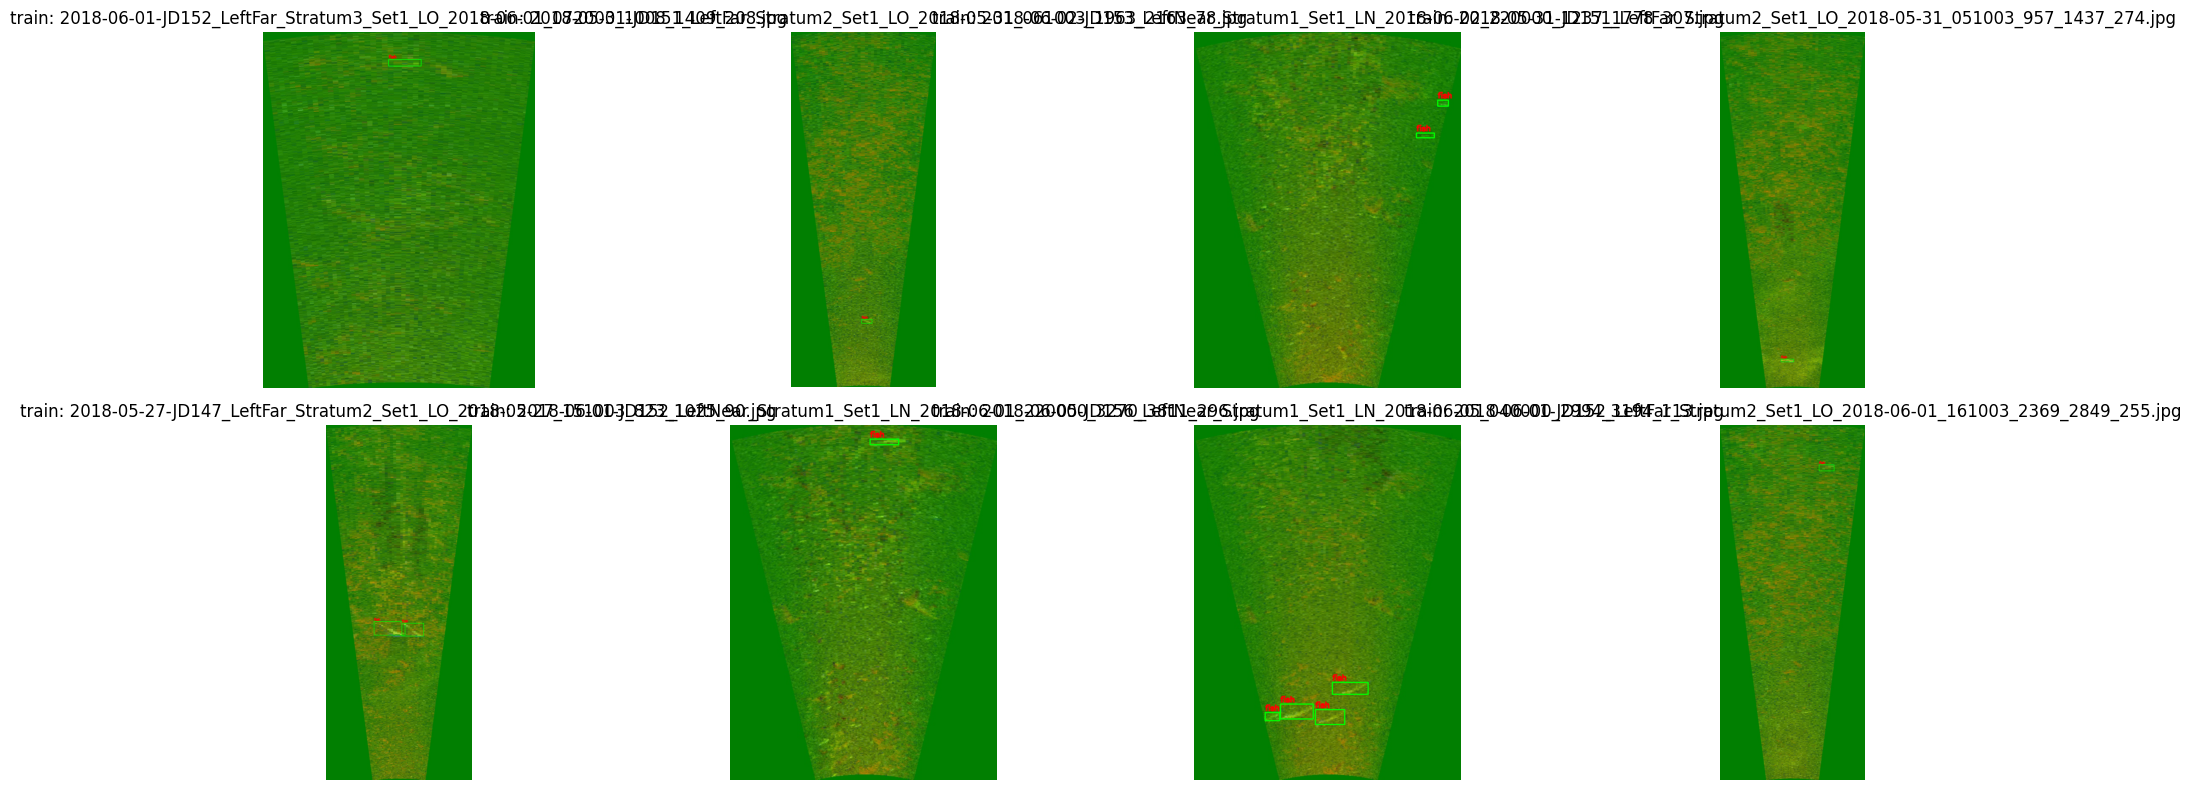

In [11]:
import os, math, random, re
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# ---------------- config ----------------
DATA_ROOT = Path("../data/CFC")
IMG_ROOT  = DATA_ROOT / "images"
LAB_ROOT  = DATA_ROOT / "labels"

SPLIT = "train"   # "train" or "test"
IMG_DIR = IMG_ROOT / SPLIT
LAB_DIR = LAB_ROOT / SPLIT

NUM_PICS = 8
COLS = 4


CFC_NAMES = [
    "fish"
]
# ----------------------------------------

def find_images(folder: Path):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
    return [p for p in folder.rglob("*") if p.suffix.lower() in exts]

def label_path_for(img_path: Path) -> Path:
    return LAB_DIR / (img_path.stem + ".txt")

def draw_yolo_labels(image_bgr, label_file: Path, names):
    img = image_bgr.copy()
    h, w = img.shape[:2]
    if not label_file.exists():
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for line in label_file.read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        # YOLO format: class cx cy w h (normalized 0..1)
        parts = re.split(r"\s+", line)
        if len(parts) < 5:
            continue
        cls = int(float(parts[0]))
        cx, cy, bw, bh = map(float, parts[1:5])

        x1 = int((cx - bw/2) * w); y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w); y2 = int((cy + bh/2) * h)
        x1 = max(0, min(w-1, x1)); y1 = max(0, min(h-1, y1))
        x2 = max(0, min(w-1, x2)); y2 = max(0, min(h-1, y2))

        color = (0,255,0)
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        label = names[cls] if 0 <= cls < len(names) else f"id{cls}"
        cv2.putText(img, label, (x1, max(0, y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2, cv2.LINE_AA)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# collect images that exist (optionally: require label file exists too)
all_imgs = find_images(IMG_DIR)
imgs_with_labels = [p for p in all_imgs if label_path_for(p).exists()]
pool = imgs_with_labels if imgs_with_labels else all_imgs

if not pool:
    raise FileNotFoundError(f"No images found in {IMG_DIR}")

sample_ids = random.sample(pool, min(NUM_PICS, len(pool)))
rows = math.ceil(len(sample_ids) / COLS)

plt.figure(figsize=(5*COLS, 4*rows))
for idx, img_path in enumerate(sample_ids, 1):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        continue
    lab_path = label_path_for(img_path)
    vis = draw_yolo_labels(img_bgr, lab_path, CFC_NAMES)

    plt.subplot(rows, COLS, idx)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{SPLIT}: {img_path.name}")
plt.tight_layout(); plt.show()
